In [1]:
#Install libraries
!pip install imblearn

Looking in indexes: https://devpi.svc.ngsci.local/root/pypi/+simple/


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from imblearn.metrics import specificity_score
import time


In [3]:
# Function to evaluate the model
def evaluate_model(model, X, y):
    """
    Calculate Evluation metrics for a given model and dataset.
    
    Parameters:
    model : sklearn model
        The trained model used to predict the labels.
    X : array-like or DataFrame
        The input data used for prediction.
    y : array-like or Series
        The true labels of the data.
    
    Returns:
    accuracy : float
        The Accuracy of the model.
    precision or PPV : float
        The Accuracy Precision or PPV the model.
    recall : float
        The Recall of the model.
    specificity : float
        The Specificity of the model.
    f1-score : float
        The f1-score of the model.
    auc_roc : float
        The auc_roc of the model.
    npv : float
        The Negative Predictive Value (NPV) of the model.
    """
    y_pred = model.predict(X)
    #y_prob = model.predict_proba(X)[:, 1]  # Probability estimates for the positive class

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    specificity = specificity_score(y, y_pred)
    
    f1 = f1_score(y, y_pred)
    npv = calculate_npv(y, y_pred)

    return accuracy, precision, recall, specificity, npv, f1

# Plot the AUC-ROC curve for each set
def plot_roc_curve(model, X, y, set_name):
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - ' + set_name)
    plt.legend(loc="lower right")
    plt.show()

    # Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, set_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {set_name}')
    plt.show()
    
def calculate_npv(y, y_pred):
    """
    Calculate the Negative Predictive Value (NPV) for a given model and dataset.
    
    Parameters:
    model : sklearn model
        The trained model used to predict the labels.
    X : array-like or DataFrame
        The input data used for prediction.
    y : array-like or Series
        The true labels of the data.
    
    Returns:
    npv : float
        The Negative Predictive Value (NPV) of the model.
    """
    
    # Generate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    # Calculate NPV
    npv = tn / (tn + fn)
    
    return npv 

def show_model_eval(model, X, y, data_type):
    metrics = evaluate_model(model, X, y)
    print("\n ",data_type, " Metrics:")
    print("Accuracy: {:.2f}".format(metrics[0]))
    print("Precision: {:.2f}".format(metrics[1]))
    print("Recall: {:.2f}".format(metrics[2]))
    print("Specificity: {:.2f}".format(metrics[3]))
    print("Negative Predictive Value: {:.2f}".format(metrics[4]))
    print("F1-Score: {:.2f}".format(metrics[5]))
    
    #Plot Confusion Matrix
    y_pred = model.predict(X)
    plot_confusion_matrix(y, y_pred, data_type)

def print_train_val_metrics(metrics_train, metrics_val):
    print("Train Set Metrics")
    print("Accuracy: {:.2f}".format(metrics_train[0]))
    print("Precision: {:.2f}".format(metrics_train[1]))
    print("Recall: {:.2f}".format(metrics_train[2]))
    print("Specificity: {:.2f}".format(metrics_train[3]))
    print("Negative Predictive Value: {:.2f}".format(metrics_train[4]))
    print("F1-Score: {:.2f}".format(metrics_train[5]))

    print("\nValidation Set Metrics:")
    print("Accuracy: {:.2f}".format(metrics_val[0]))
    print("Precision: {:.2f}".format(metrics_val[1]))
    print("Recall: {:.2f}".format(metrics_val[2]))
    print("Specificity: {:.2f}".format(metrics_val[3]))
    print("Negative Predictive Value: {:.2f}".format(metrics_val[4]))
    print("F1-Score: {:.2f}".format(metrics_val[5]))

def one_hot_encode_sex(df):
    # Create a new DataFrame with one-hot encoded columns
    encoded_df = pd.get_dummies(df, columns=['sex'])
    
    # Rename the encoded columns for clarity
    encoded_df = encoded_df.rename(columns={'sex_female': 'female', 'sex_male': 'male'})
    
    return encoded_df

def convert_TrueFalse_column(df, column):
    """
    Converts the values in the column of the dataframe.
    Changes 'True' to 1 and 'False' to 0.

    Parameters:
    df (pd.DataFrame): Input dataframe with a column.

    Returns:
    pd.DataFrame: Dataframe with converted column.
    """
    # Mapping dictionary
    mapping = {False: 0, True: 1}
    
    # Apply the mapping
    df[column] = df[column].map(mapping)
    
    return df

In [4]:
#Read data
filter_dir = os.path.join('/','home','ngsci','project','csv_files_and_genarators')
data_positive_label = pd.read_csv(os.path.join(filter_dir,'data_OHCA_preECGs_w24h.csv'))
data_negative_label = pd.read_csv(os.path.join(filter_dir,'data_ctrg_preECGs_wNdays.csv'))

print(data_positive_label.shape)
#print(data_positive_label.head(5))
#print(data_negative_label.head(5))
print(data_negative_label.shape)

#Concatanete both datasets
dataset_df = pd.concat([data_negative_label,data_positive_label], ignore_index=True)

#Remove IDs
dataset_df = dataset_df.drop(columns=['ecg_id', 'patient_id'])

(19, 26)
(247, 26)


In [5]:
ran_num=2
#Apply SMOTE to minority class
X = dataset_df.drop('label', axis=1)  # Features
y = dataset_df['label']  # Labels

# Count the current number of labels
count_label_1 = sum(y == 1)

# Initialize SMOTE with the desired ratio
resampling_factor=3
smote = SMOTE(sampling_strategy={1: count_label_1*resampling_factor}, random_state=ran_num)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new dataframe with the resampled data
resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['label'])], axis=1)

print("Original dataset shape:", dataset_df.shape)
print("Resampled dataset shape:", resampled_df.shape)
print("Original class distribution:\n", dataset_df['label'].value_counts())
print("Resampled class distribution:\n", resampled_df['label'].value_counts())

Original dataset shape: (266, 24)
Resampled dataset shape: (304, 24)
Original class distribution:
 label
0    247
1     19
Name: count, dtype: int64
Resampled class distribution:
 label
0    247
1     57
Name: count, dtype: int64


In [6]:
# Split the dataset into training, validation, and testing sets
train_df, val_df = train_test_split(resampled_df, test_size=0.3, random_state=ran_num)

# Define the features (X) and target (y)
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_val = val_df.drop('label', axis=1)
y_val = val_df['label']

Train Set Metrics
Accuracy: 1.00
Precision: 1.00
Recall: 0.98
Specificity: 1.00
Negative Predictive Value: 0.99
F1-Score: 0.99

Validation Set Metrics:
Accuracy: 0.95
Precision: 0.92
Recall: 0.73
Specificity: 0.99
Negative Predictive Value: 0.95
F1-Score: 0.81


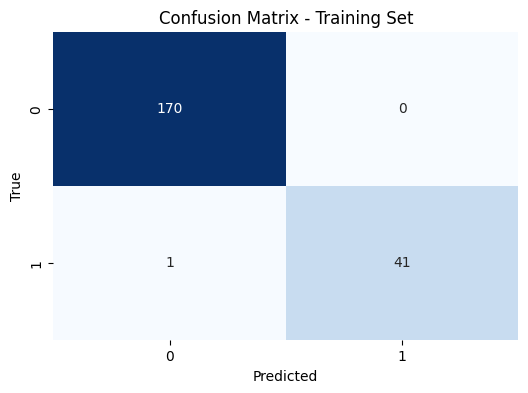

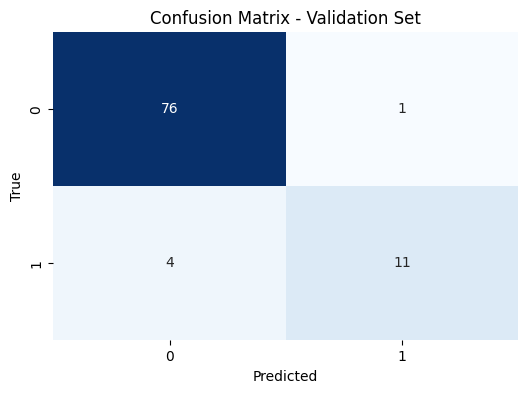

In [7]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=10, random_state=ran_num)
# Fit the model
model.fit(X_train, y_train)

# fit the classifier to the training data
model.fit(X_train, y_train)

# Evaluate the model on training, validation, and test sets
metrics_train = evaluate_model(model, X_train, y_train)
metrics_val = evaluate_model(model, X_val, y_val)

# Print the metrics
print_train_val_metrics(metrics_train, metrics_val)
    
#Plot Confusion Matrix Training Set
y_train_pred = model.predict(X_train)
plot_confusion_matrix(y_train, y_train_pred, 'Training Set')

#Plot Confusion Matrix Validation Set
y_val_pred = model.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred, 'Validation Set')


In [8]:
#Define everything for CV searching
inner_folds = 3
outer_folds = 5

# configure the cross-validation procedure
cv_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=ran_num)
cv_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=ran_num)

models = RandomForestClassifier(random_state=ran_num)
# define search space
space = dict()
space['n_estimators'] = [10, 15, 20]
space['min_samples_split'] = [5, 10, 15]
space['max_features'] = [2, 4, 6]
space['max_leaf_nodes'] = [10, 15, 20]
space['max_depth'] = [5, 7, 10]

# define search
search = GridSearchCV(models, space, scoring='f1', n_jobs=1, cv=cv_inner, refit=True)

In [9]:
import time
start = time.perf_counter()

# Perform nested cross-validation
outer_F1 = []
outer_Pre = []
outer_Sens = []
outer_Spec = []
outer_Acc = []
outer_NPV = []

for train_idx, test_idx in cv_outer.split(X_resampled, y_resampled):
    X_cv_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
    y_cv_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]
    
    search.fit(X_cv_train, y_cv_train)

    # Train the model with the best hyperparameters on the outer training fold
    best_model = search.best_estimator_
    best_model.fit(X_cv_train, y_cv_train)

    # Evaluate the model on the outer validation fold
    y_pred = best_model.predict(X_test)
    outer_F1.append(f1_score(y_test, y_pred))
    outer_Pre.append(precision_score(y_test, y_pred))
    outer_Sens.append(recall_score(y_test, y_pred))
    outer_Acc.append(accuracy_score(y_test, y_pred))
    outer_Spec.append(specificity_score(y_test, y_pred))
    npv = calculate_npv(y_test, y_pred)
    outer_NPV.append(npv)
    
# Report the mean and standard deviation of the scores across the outer folds
#print(f"F1 nested cross-validation scores: {outer_scores}")
print(f"F1 mean score: {np.mean(outer_F1):.3f} +/- {np.std(outer_F1):.3f}")
print(f"Precision mean: {np.mean(outer_Pre):.3f} +/- {np.std(outer_Pre):.3f}")
print(f"Sensitivity mean: {np.mean(outer_Sens):.3f} +/- {np.std(outer_Sens):.3f}")
print(f"Specificity mean: {np.mean(outer_Spec):.3f} +/- {np.std(outer_Spec):.3f}")
print(f"NPV mean: {np.mean(outer_NPV):.3f} +/- {np.std(outer_NPV):.3f}")
print(f"Accuracy mean: {np.mean(outer_Acc):.3f} +/- {np.std(outer_Acc):.3f}")

end = time.perf_counter()
print(f"Time taken: {end - start:.6f} seconds")


F1 mean score: 0.715 +/- 0.097
Precision mean: 0.931 +/- 0.057
Sensitivity mean: 0.595 +/- 0.125
Specificity mean: 0.988 +/- 0.010
NPV mean: 0.915 +/- 0.022
Accuracy mean: 0.915 +/- 0.019
Time taken: 120.511456 seconds


In [10]:
start = time.perf_counter()

best_model = search.fit(X_resampled, y_resampled).best_estimator_
print(best_model)
metrics = ['accuracy', 'precision', 'recall', 'f1']

#caculate the metrics using cross validation
for metric in metrics:
    score = cross_val_score(best_model, X_resampled, y_resampled, scoring=metric, cv=cv_outer, n_jobs=-1)
    print(metric, ': mean %.3f and standard deviation (%.3f)' % (np.mean(score), np.std(score)))

#find the specificity
specificity = cross_val_score(best_model, X_resampled, y_resampled, scoring=make_scorer(recall_score, pos_label=0))
print('specificity: mean %.3f and standard deviation (%.3f)' % (np.mean(specificity), np.std(specificity)))

#find the npv
npvs = cross_val_score(best_model, X_resampled, y_resampled, scoring=make_scorer(precision_score, pos_label=0))
print('npv: mean %.3f and standard deviation (%.3f)' % (np.mean(npvs), np.std(npvs)))

end = time.perf_counter()
print(f"Time taken: {end - start:.6f} seconds")

RandomForestClassifier(max_depth=7, max_features=6, max_leaf_nodes=15,
                       min_samples_split=5, n_estimators=15, random_state=2)
accuracy : mean 0.905 and standard deviation (0.019)
precision : mean 0.845 and standard deviation (0.094)
recall : mean 0.614 and standard deviation (0.092)
f1 : mean 0.704 and standard deviation (0.069)
specificity: mean 0.988 and standard deviation (0.016)
npv: mean 0.915 and standard deviation (0.033)
Time taken: 27.822445 seconds


In [10]:
# automatic nested cross-validation for random forest on a classification dataset

# execute the nested cross-validation
scores = cross_val_score(search, X_resampled, y_resampled, scoring='f1', cv=cv_outer, n_jobs=-1)

# report performance
print('f1-score: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

f1-score: 0.747 (0.142)


# end 

In [12]:

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(3, 20).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(5, 20, 50).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state=ran_num)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=ran_num)

# Fit 
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 5, 5, 5, 5, 6,
                                                           6, 6, 7, 7, 7, 8, 8,
                                                           8, 8, 9, 9, 9, 10,
                                                           10, 10, 11, 11, 11,
                                                           12, 12, 12, 12, 13,
                                                           13, ...],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 3,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,  8,  8,
        8,  9,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14,
       14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 20])},
                   random_state=42, scoring='roc_auc', verbose=1)

{'n_estimators': 15, 'min_samples_split': 10, 'max_leaf_nodes': 16, 'max_features': 'auto', 'max_depth': 7, 'bootstrap': False}
Training Set Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       147
           1       1.00      0.94      0.97        35

    accuracy                           0.99       182
   macro avg       0.99      0.97      0.98       182
weighted avg       0.99      0.99      0.99       182

Training Set Confusion Matrix:
[[147   0]
 [  2  33]]


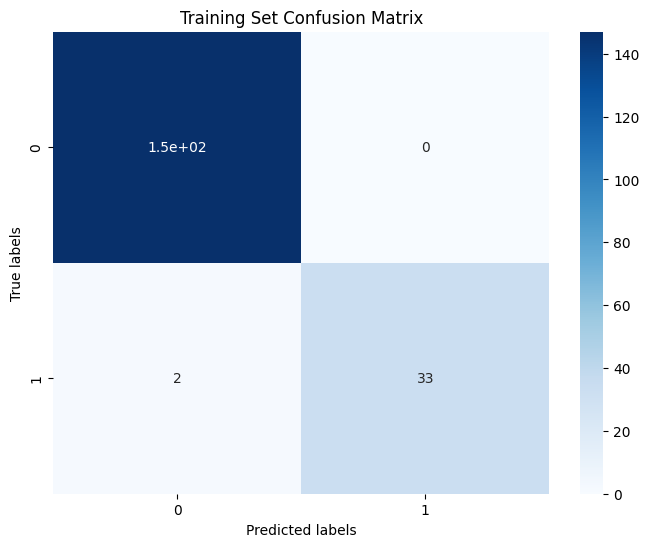


Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        51
           1       1.00      0.40      0.57        10

    accuracy                           0.90        61
   macro avg       0.95      0.70      0.76        61
weighted avg       0.91      0.90      0.88        61

Validation Set Confusion Matrix:
[[51  0]
 [ 6  4]]


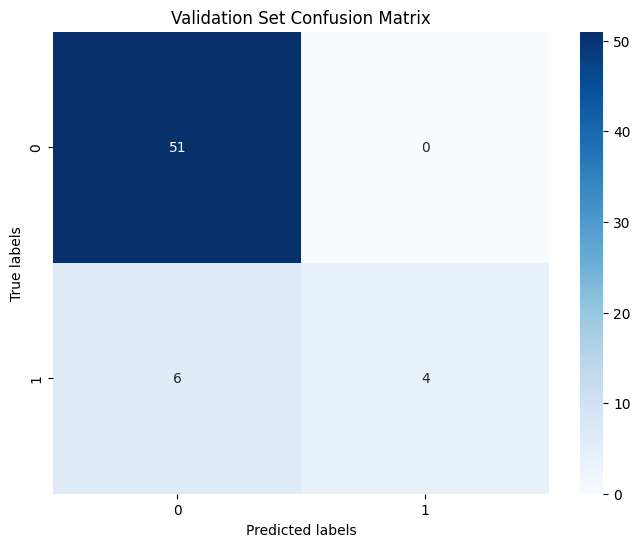

In [13]:
print(rs.best_params_)
best_model = rs.best_estimator_

# Calculate metrics for training set
y_pred_train = best_model.predict(X_train)
print("Training Set Metrics:")
print(classification_report(y_train, y_pred_train))
train_cm = confusion_matrix(y_train, y_pred_train)
print("Training Set Confusion Matrix:")
print(train_cm)

# Plot training set confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Training Set Confusion Matrix")
plt.show()

# Calculate metrics for validation set
y_pred_val = best_model.predict(X_val)
print("\nValidation Set Metrics:")
print(classification_report(y_val, y_pred_val))
val_cm = confusion_matrix(y_val, y_pred_val)
print("Validation Set Confusion Matrix:")
print(val_cm)

# Plot validation set confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Blues')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Validation Set Confusion Matrix")
plt.show()

Test Accuracy: 0.836

Test Set Metrics:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        49
           1       0.67      0.33      0.44        12

    accuracy                           0.84        61
   macro avg       0.76      0.65      0.67        61
weighted avg       0.82      0.84      0.81        61

Test Set Confusion Matrix:
[[47  2]
 [ 8  4]]


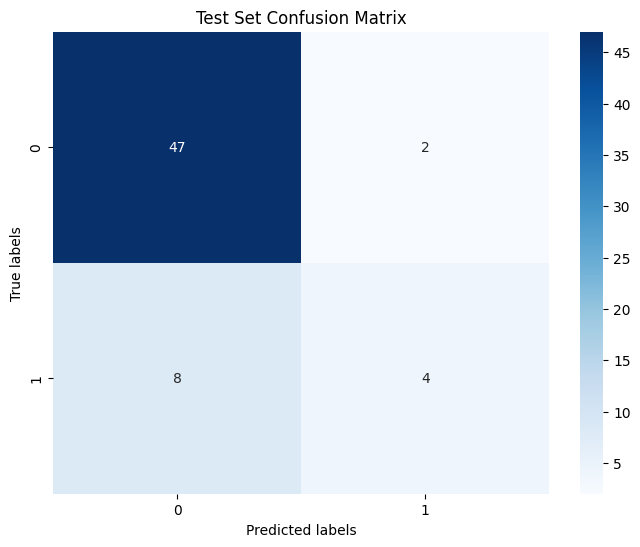

In [14]:
# Evaluate the model on the test set
y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy:.3f}')

# Calculate metrics for test set
print("\nTest Set Metrics:")
print(classification_report(y_test, y_pred_test))
test_cm = confusion_matrix(y_test, y_pred_test)
print("Test Set Confusion Matrix:")
print(test_cm)

# Plot validation set confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Test Set Confusion Matrix")
plt.show()

Train Set Metrics:
Accuracy: 0.99
Precision: 1.00
Recall: 0.94
Specificity: 1.00
Negative Predictive Value: 0.99
F1-Score: 0.97
AUC-ROC: 1.00

Validation Set Metrics:
Accuracy: 0.90
Precision: 1.00
Recall: 0.40
Specificity: 1.00
Negative Predictive Value: 0.89
F1-Score: 0.57
AUC-ROC: 0.99


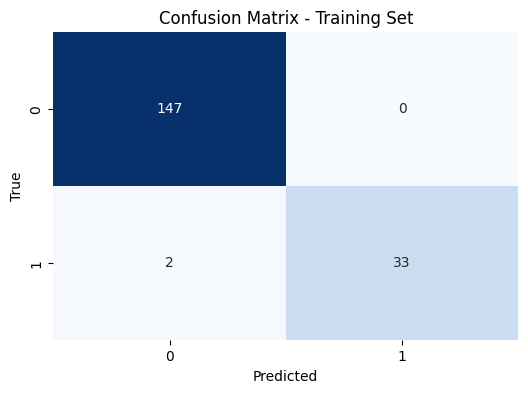

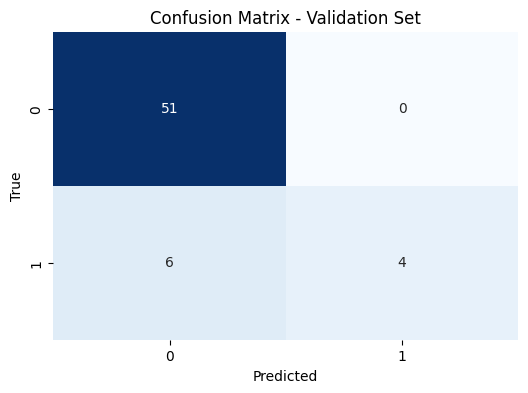

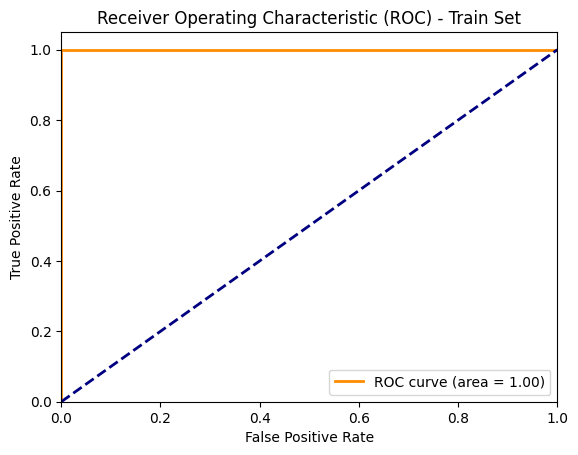

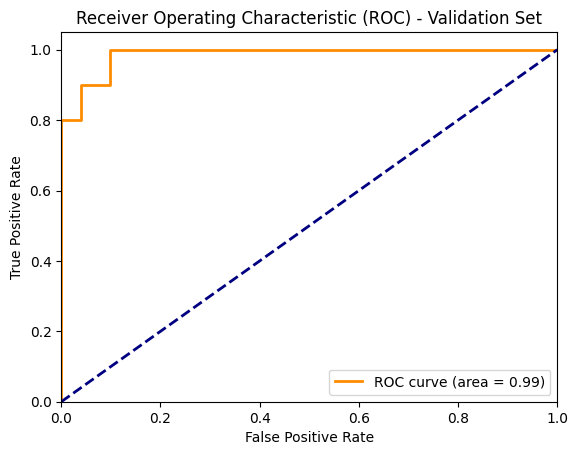

In [15]:

# Fit the model
#clf.fit(X_train, y_train)

# Evaluate the model on training, validation, and test sets
metrics_train = evaluate_model(best_model, X_train, y_train)
metrics_val = evaluate_model(best_model, X_val, y_val)

# Print the metrics
print("Train Set Metrics:")
print("Accuracy: {:.2f}".format(metrics_train[0]))
print("Precision: {:.2f}".format(metrics_train[1]))
print("Recall: {:.2f}".format(metrics_train[2]))
print("Specificity: {:.2f}".format(metrics_train[3]))
print("Negative Predictive Value: {:.2f}".format(metrics_train[4]))
print("F1-Score: {:.2f}".format(metrics_train[5]))
print("AUC-ROC: {:.2f}".format(metrics_train[6]))

print("\nValidation Set Metrics:")
print("Accuracy: {:.2f}".format(metrics_val[0]))
print("Precision: {:.2f}".format(metrics_val[1]))
print("Recall: {:.2f}".format(metrics_val[2]))
print("Specificity: {:.2f}".format(metrics_val[3]))
print("Negative Predictive Value: {:.2f}".format(metrics_val[4]))
print("F1-Score: {:.2f}".format(metrics_val[5]))
print("AUC-ROC: {:.2f}".format(metrics_val[6]))

#Plot Confusion Matrix Training Set
y_train_pred = best_model.predict(X_train)
plot_confusion_matrix(y_train, y_train_pred, 'Training Set')

#Plot Confusion Matrix Validation Set
y_val_pred = best_model.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred, 'Validation Set')


# Plot ROC curves for train, validation, and test sets
plot_roc_curve(best_model, X_train, y_train, 'Train Set')
plot_roc_curve(best_model, X_val, y_val, 'Validation Set')



Test Set Metrics:
Accuracy: 0.84
Precision: 0.67
Recall: 0.33
Specificity: 0.96
Negative Predictive Value: 0.85
F1-Score: 0.44
AUC-ROC: 0.89


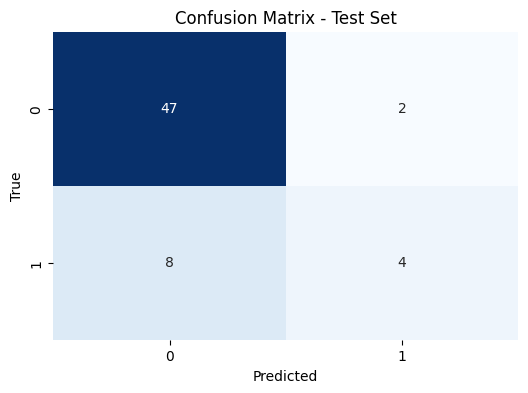

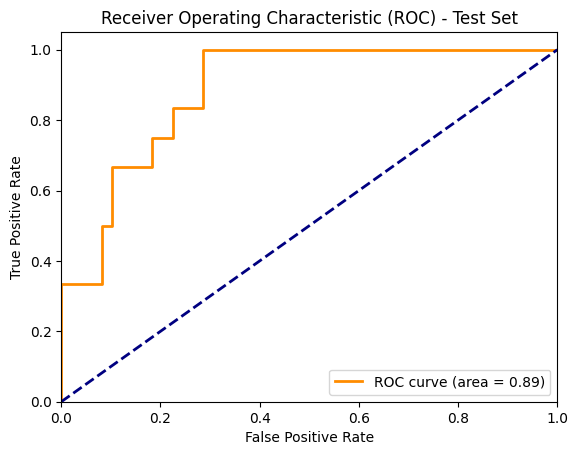

In [16]:
metrics_test = evaluate_model(best_model, X_test, y_test)

print("\nTest Set Metrics:")
print("Accuracy: {:.2f}".format(metrics_test[0]))
print("Precision: {:.2f}".format(metrics_test[1]))
print("Recall: {:.2f}".format(metrics_test[2]))
print("Specificity: {:.2f}".format(metrics_test[3]))
print("Negative Predictive Value: {:.2f}".format(metrics_test[4]))
print("F1-Score: {:.2f}".format(metrics_test[5]))
print("AUC-ROC: {:.2f}".format(metrics_test[6]))

#Plot Confusion Matrix Test Set
y_test_pred = best_model.predict(X_test)
plot_confusion_matrix(y_test, y_test_pred, 'Test Set')

#Plot AUC-ROC curve for Test set
plot_roc_curve(best_model, X_test, y_test, 'Test Set')

In [17]:
#Get the importance of each feature
rf_feature_importance = get_feature_importance(best_model, X, y)
rf_feature_importance.head(10)

,feature,importance
16,V1_RDUR,0.148319
19,V1_QRSA,0.134840
15,V1_RAMP,0.100985
5,I_RAMP,0.090139
11,V1_PAMP,0.062797
1,I_PAMP,0.052246
12,V1_PDUR,0.049926
20,V1_QRSDEF,0.049047
8,I_SDUR,0.048029
2,I_PDUR,0.040774


In [31]:
# automatic nested cross-validation for random forest on a classification dataset
#from numpy import mean
#from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# configure the cross-validation procedure
cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=ran_num)
# define the model
model = RandomForestClassifier(random_state=ran_num)
# define search space
space = dict()
space['n_estimators'] = [10, 15, 20]
space['min_samples_split'] = [5, 10, 15]
space['max_features'] = [2, 4, 6]
space['max_leaf_nodes'] = [10, 15, 20]
space['max_depth'] = [5, 7, 10]

# define search
search = GridSearchCV(model, space, scoring='f1', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=ran_num)
# execute the nested cross-validation
scores = cross_val_score(search, X_resampled, y_resampled, scoring='f1', cv=cv_outer, n_jobs=-1)
# report performance
print('f1-score: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

f1-score: 0.898 (0.028)


In [32]:
#Evaluate the best_model
best_model = search.fit(X_resampled, y_resampled).best_estimator_
metrics = ['accuracy', 'precision', 'recall', 'f1']

#caculate the metrics using cross validation
for metric in metrics:
    score = cross_val_score(best_model, X_resampled, y_resampled, scoring=metric, cv=cv_outer, n_jobs=-1)
    print(metric, ': mean %.3f and standard deviation (%.3f)' % (np.mean(score), np.std(score)))

#find the specificity
#from sklearn.metrics import recall_score
specificity = cross_val_score(best_model, X_resampled, y_resampled, scoring=make_scorer(recall_score, pos_label=0))
print('specificity: mean %.3f and standard deviation (%.3f)' % (np.mean(specificity), np.std(specificity)))

#find the npv
#from sklearn.metrics import make_scorer, precision_score
npvs = cross_val_score(best_model, X_resampled, y_resampled, scoring=make_scorer(precision_score, pos_label=0))
print('npv: mean %.3f and standard deviation (%.3f)' % (np.mean(npvs), np.std(npvs)))

accuracy : mean 0.918 and standard deviation (0.041)
precision : mean 0.887 and standard deviation (0.147)
recall : mean 0.645 and standard deviation (0.156)
f1 : mean 0.738 and standard deviation (0.149)
specificity: mean 0.984 and standard deviation (0.015)
npv: mean 0.934 and standard deviation (0.043)


In [30]:
best_model

RandomForestClassifier(max_depth=10, max_features=6, max_leaf_nodes=20,
                       min_samples_split=5, n_estimators=20, random_state=1)